# scATAC-seq preprocessing using pycisTopic

### Set-Up Environment

In [1]:
#supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
_stderr = sys.stderr
null = open(os.devnull,'wb')

In [2]:
# set the working directory
work_dir = '/g/scb/zaugg/deuner/SCENIC+/'
# set tmp directory
tmp_dir = '/g/scb/zaugg/deuner/SCENIC+/tmp/combined/'
# set the figures directory
fig_dir = '/g/scb/zaugg/deuner/SCENIC+/figures/'

In [3]:
# Load libraries
import scanpy as sc
import numpy as np
import matplotlib.pyplot as pl
from scipy import io
import pandas as pd

In [4]:
# Specify the location of the ATAC fragments file, this is the main input into pycisTopic.
fragments_dict = {'timecourse': os.path.join(work_dir, 'inputdata/timecourse_fragments_translated_ordered4.tsv'),
                 'Neuron': os.path.join(work_dir, 'inputdata/Neuron_fragments_translated_ordered5.tsv'),
                 'NPC': os.path.join(work_dir, 'inputdata/NPC_fragments_translated_ordered5.tsv'),
                 'cocultured28': os.path.join(work_dir, 'inputdata/cocultured28_fragments_translated_ordered5.tsv')}

### Generate pseudobulk ATAC-seq profiles, call peaks and generate a consensus peak set

In [8]:
# First load the cell type annotation we generated in the scRNA-seq analysis above.
adata = sc.read_h5ad(os.path.join(tmp_dir, 'combined.nomicro.adata.h5ad'))

In [9]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.ribo,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,pANN_0.25_0.005_794,...,wsnn_res.8,wsnn_res.9,wsnn_res.10,wsnn_res.12,wsnn_res.14,wsnn_res.16,wsnn_res.18,wsnn_res.20,celltype_wnn,barcode
timecourse_AAACAGCCAGCCAGTT,timecourse,5020.0,2676,6.155378,3.705179,6037.0,2676,7,25,0.084507,...,51,48,44,31,27,51,35,25,diff-NPC,AAACCGTACCCGCTGT
timecourse_AAACAGCCAGGCGAGT,timecourse,4719.0,2179,0.190718,0.466200,6032.0,2178,14,117,0.239437,...,72,96,96,109,114,120,115,117,neuron-1,GTAGGTTACCCGCTGT
timecourse_AAACAGCCAGTAAAGC,timecourse,3832.0,2004,0.287056,0.730689,5979.0,2008,12,50,0.183099,...,46,34,32,26,23,14,62,50,diff-neuron,CTAGTAAACCCGCTGT
timecourse_AAACAGCCATAAGTCT,timecourse,7329.0,3535,1.159776,1.132487,7247.0,3535,8,151,0.154930,...,52,47,49,50,47,34,147,151,hiPSC-2,TGGCATGACCCGCTGT
timecourse_AAACAGCCATAGGCGA,timecourse,4511.0,2253,7.337619,1.906451,6061.0,2253,7,51,0.140845,...,19,11,12,41,36,70,52,51,diff-NPC,TTTGTGCACCCGCTGT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cocultured28_TTTGTGAAGTCTATGA,cocultured28,11717.0,3893,0.162158,0.187761,7918.0,3746,5,72,NaN,...,25,22,14,55,49,107,105,72,neuron-2,AGCAATTGACACCTAC
cocultured28_TTTGTGGCAGCAAGTG,cocultured28,6845.0,2998,0.613587,0.555150,6845.0,2998,14,85,NaN,...,59,88,89,100,103,105,93,85,neuron-4,TGATTAGACACCAAAC
cocultured28_TTTGTGTTCTCGCCTG,cocultured28,9557.0,3435,0.292979,0.282515,7697.0,3433,6,39,NaN,...,24,15,70,79,78,73,50,39,neuron-3,GTTAAAGCTTGAGAAC
cocultured28_TTTGTGTTCTTAGCCC,cocultured28,1732.0,1112,2.078522,0.577367,5364.0,1614,6,123,NaN,...,45,33,61,29,21,45,73,123,neuron-3,ACTAAGACTTGAGAAC


In [10]:
# Set barcodes as cell names (remove sample name)
new_names = []
for i in range(len(adata.obs_names)):
    new_name =  str.split(adata.obs_names[i], "_")[1] #adata.obs_names[i][11:]
    new_names.append(new_name)

adata.obs_names = new_names
# cell names: rna barcodes, barcode column: atac barcodes

In [11]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.ribo,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,pANN_0.25_0.005_794,...,wsnn_res.8,wsnn_res.9,wsnn_res.10,wsnn_res.12,wsnn_res.14,wsnn_res.16,wsnn_res.18,wsnn_res.20,celltype_wnn,barcode
AAACAGCCAGCCAGTT,timecourse,5020.0,2676,6.155378,3.705179,6037.0,2676,7,25,0.084507,...,51,48,44,31,27,51,35,25,diff-NPC,AAACCGTACCCGCTGT
AAACAGCCAGGCGAGT,timecourse,4719.0,2179,0.190718,0.466200,6032.0,2178,14,117,0.239437,...,72,96,96,109,114,120,115,117,neuron-1,GTAGGTTACCCGCTGT
AAACAGCCAGTAAAGC,timecourse,3832.0,2004,0.287056,0.730689,5979.0,2008,12,50,0.183099,...,46,34,32,26,23,14,62,50,diff-neuron,CTAGTAAACCCGCTGT
AAACAGCCATAAGTCT,timecourse,7329.0,3535,1.159776,1.132487,7247.0,3535,8,151,0.154930,...,52,47,49,50,47,34,147,151,hiPSC-2,TGGCATGACCCGCTGT
AAACAGCCATAGGCGA,timecourse,4511.0,2253,7.337619,1.906451,6061.0,2253,7,51,0.140845,...,19,11,12,41,36,70,52,51,diff-NPC,TTTGTGCACCCGCTGT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGAAGTCTATGA,cocultured28,11717.0,3893,0.162158,0.187761,7918.0,3746,5,72,NaN,...,25,22,14,55,49,107,105,72,neuron-2,AGCAATTGACACCTAC
TTTGTGGCAGCAAGTG,cocultured28,6845.0,2998,0.613587,0.555150,6845.0,2998,14,85,NaN,...,59,88,89,100,103,105,93,85,neuron-4,TGATTAGACACCAAAC
TTTGTGTTCTCGCCTG,cocultured28,9557.0,3435,0.292979,0.282515,7697.0,3433,6,39,NaN,...,24,15,70,79,78,73,50,39,neuron-3,GTTAAAGCTTGAGAAC
TTTGTGTTCTTAGCCC,cocultured28,1732.0,1112,2.078522,0.577367,5364.0,1614,6,123,NaN,...,45,33,61,29,21,45,73,123,neuron-3,ACTAAGACTTGAGAAC


In [12]:
cell_data = adata.obs
cell_data['sample_id'] = cell_data['orig.ident']
cell_data['celltype'] = cell_data['celltype_wnn'].astype(str) # set data type of the celltype column to str, otherwise the export_pseudobulk function will complain.

In [13]:
cell_data

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.ribo,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,pANN_0.25_0.005_794,...,wsnn_res.9,wsnn_res.10,wsnn_res.12,wsnn_res.14,wsnn_res.16,wsnn_res.18,wsnn_res.20,celltype_wnn,barcode,sample_id
AAACAGCCAGCCAGTT,timecourse,5020.0,2676,6.155378,3.705179,6037.0,2676,7,25,0.084507,...,48,44,31,27,51,35,25,diff-NPC,AAACCGTACCCGCTGT,timecourse
AAACAGCCAGGCGAGT,timecourse,4719.0,2179,0.190718,0.466200,6032.0,2178,14,117,0.239437,...,96,96,109,114,120,115,117,neuron-1,GTAGGTTACCCGCTGT,timecourse
AAACAGCCAGTAAAGC,timecourse,3832.0,2004,0.287056,0.730689,5979.0,2008,12,50,0.183099,...,34,32,26,23,14,62,50,diff-neuron,CTAGTAAACCCGCTGT,timecourse
AAACAGCCATAAGTCT,timecourse,7329.0,3535,1.159776,1.132487,7247.0,3535,8,151,0.154930,...,47,49,50,47,34,147,151,hiPSC-2,TGGCATGACCCGCTGT,timecourse
AAACAGCCATAGGCGA,timecourse,4511.0,2253,7.337619,1.906451,6061.0,2253,7,51,0.140845,...,11,12,41,36,70,52,51,diff-NPC,TTTGTGCACCCGCTGT,timecourse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGAAGTCTATGA,cocultured28,11717.0,3893,0.162158,0.187761,7918.0,3746,5,72,NaN,...,22,14,55,49,107,105,72,neuron-2,AGCAATTGACACCTAC,cocultured28
TTTGTGGCAGCAAGTG,cocultured28,6845.0,2998,0.613587,0.555150,6845.0,2998,14,85,NaN,...,88,89,100,103,105,93,85,neuron-4,TGATTAGACACCAAAC,cocultured28
TTTGTGTTCTCGCCTG,cocultured28,9557.0,3435,0.292979,0.282515,7697.0,3433,6,39,NaN,...,15,70,79,78,73,50,39,neuron-3,GTTAAAGCTTGAGAAC,cocultured28
TTTGTGTTCTTAGCCC,cocultured28,1732.0,1112,2.078522,0.577367,5364.0,1614,6,123,NaN,...,33,61,29,21,45,73,123,neuron-3,ACTAAGACTTGAGAAC,cocultured28


In [14]:
# Generate pseudobulk profiles 
# Get chromosome sizes (for hg38 here)
import pyranges as pr
import requests
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [15]:
# Check chromsizes
chromsizes

,Chromosome,Start,End
0,GL000008.2,0,209709
1,GL000009.2,0,201709
2,GL000194.1,0,191469
3,GL000195.1,0,182896
4,GL000205.2,0,185591
...,...,...,...
450,chr21,0,46709983
451,chr22,0,50818468
452,chrM,0,16569
453,chrX,0,156040895


In [16]:
# Load fragments
timecourse_fragments = pd.read_table(os.path.join(work_dir, 'inputdata/timecourse_fragments_translated_ordered4.tsv'), header=None)
Neuron_fragments = pd.read_table(os.path.join(work_dir, 'inputdata/Neuron_fragments_translated_ordered5.tsv'), header=None)
NPC_fragments = pd.read_table(os.path.join(work_dir, 'inputdata/NPC_fragments_translated_ordered5.tsv'), header=None)
cocultured28_fragments = pd.read_table(os.path.join(work_dir, 'inputdata/cocultured28_fragments_translated_ordered5.tsv'), header=None)

In [17]:
timecourse_fragments.head

<bound method NDFrame.head of               0         1         2                 3    4  5
0          chr1     10080     10302  ACCTGCTACCAAAGCC  223  +
1          chr1     10086     10180  CAGGAGGACGTTATGG   95  +
2          chr1     10092     10326  CTATTGACTCTCTAGG  235  +
3          chr1     10096     10266  GACTCAAACCAGGTTG  171  +
4          chr1     10098     10267  TGCTTCAACGTTAAGC  170  +
...         ...       ...       ...               ...  ... ..
147578543  chrY  56885669  56885700  TCTCTATTGTGGTTCA   32  +
147578544  chrY  56885674  56885851  CAACATAACTAGTGCG  178  +
147578545  chrY  56886505  56886586  AGATTAGCTCAAGGGC   82  +
147578546  chrY  56886816  56887006  GGGCTATGAGGATGTC  191  +
147578547  chrY  56887086  56887442  ACCCGCTGAAGCAACC  357  +

[147578548 rows x 6 columns]>

In [18]:
Neuron_fragments.head

<bound method NDFrame.head of               0         1         2                 3    4  5
0          chr1     10080     10267  CAGTAAGCTAAGACTA  188  +
1          chr1     10080     10308  GTCGCTATGAACGGTA  229  +
2          chr1     10080     10346  CGCAAGGCTAGGCTAG  267  +
3          chr1     10086     10278  TGGGAGGACATGTTTC  193  +
4          chr1     10086     10285  CTCCATAACCTCATCA  200  +
...         ...       ...       ...               ...  ... ..
147532768  chrY  56886517  56886577  TGACATAACACCAAAC   61  +
147532769  chrY  56886632  56886839  ACCGCCACTAGAGATT  208  +
147532770  chrY  56886840  56887197  ACCGCCACTAGAGATT  358  +
147532771  chrY  56887032  56887391  CCTTTCTGAGGTAACC  360  +
147532772  chrY  56887203  56887362  TTTAGTGCTGTGAGAC  160  +

[147532773 rows x 6 columns]>

In [19]:
NPC_fragments.head

<bound method NDFrame.head of               0         1         2                 3    4  5
0          chr1     10087     10524  TCGGTTTACTGACTTC  438  +
1          chr1     10091     10209  CAGTAAGCTGGCTATT  119  +
2          chr1     10092     10285  TACGCACCTCACTTGG  194  +
3          chr1     10092     10303  GATTCAAGAAGTAAGG  212  +
4          chr1     10098     10279  CTCATTGACGTAACGT  182  +
...         ...       ...       ...               ...  ... ..
133450660  chrY  56884277  56884463  CTATCGGCTACTTCGA  187  +
133450661  chrY  56885529  56885732  ACTTGTCGACAGAATC  204  +
133450662  chrY  56885538  56885611  CATTAGTCTAACCGTT   74  +
133450663  chrY  56885551  56885736  CTATTGCACGGTACTA  186  +
133450664  chrY  56886003  56886189  AAGAACAACTTCCTTT  187  +

[133450665 rows x 6 columns]>

In [20]:
cocultured28_fragments.head

<bound method NDFrame.head of              0         1         2                 3    4  5
0         chr1     10086     10179  CGACTTGCTAACCCGC   94  +
1         chr1     10127     10271  ACAGCCTTGAATCTCA  145  +
2         chr1     10132     10302  CTTAGTGTGTGCAGCC  171  +
3         chr1     10143     10209  TCCCTCATGTCCTTTA   67  +
4         chr1     10144     10210  CATAACGGAAGGTGGG   67  +
...        ...       ...       ...               ...  ... ..
98110905  chrY  56886733  56886907  CCCGATTGACTCACAC  175  +
98110906  chrY  56886815  56887012  CCCGATTGATTAGCAG  198  +
98110907  chrY  56886964  56887171  TAGGCTAGACCGGGTA  208  +
98110908  chrY  56887003  56887183  GAAACTCACCGGCTAA  181  +
98110909  chrY  56887021  56887199  ACGGAACCTAACCCGC  179  +

[98110910 rows x 6 columns]>

In [18]:
# # remove sample named from barcodes (except for timecourse which already does not contain them)
# # (does not matter too much as fragments are taken directly from their directory). I have already removed the sample names via bash command lines
# Neuron_fragments[3] = Neuron_fragments[3].str.split("_").str[1]
# NPC_fragments[3] = NPC_fragments[3].str.split("_").str[1]
# cocultured28_fragments[3] = cocultured28_fragments[3].str.split("_").str[1]

'''
for i in range(len(Neuron_fragments)):
    frag = Neuron_fragments[3][i]
    frag_split = str.split(frag, "_")
    Neuron_fragments[3][i] = frag_split[1]

for i in range(len(NPC_fragments)):
    frag = NPC_fragments[3][i]
    frag_split = str.split(frag, "_")
    NPC_fragments[3][i] = frag_split[1]

for i in range(len(cocultured28_fragments)):
    frag = cocultured28_fragments[3][i]
    frag_split = str.split(frag, "_")
    cocultured28_fragments[3][i] = frag_split[1]
'''

'\nfor i in range(len(Neuron_fragments)):\n    frag = Neuron_fragments[3][i]\n    frag_split = str.split(frag, "_")\n    Neuron_fragments[3][i] = frag_split[1]\n\nfor i in range(len(NPC_fragments)):\n    frag = NPC_fragments[3][i]\n    frag_split = str.split(frag, "_")\n    NPC_fragments[3][i] = frag_split[1]\n\nfor i in range(len(cocultured28_fragments)):\n    frag = cocultured28_fragments[3][i]\n    frag_split = str.split(frag, "_")\n    cocultured28_fragments[3][i] = frag_split[1]\n'

In [21]:
cocultured28_fragments[3]

0           CGACTTGCTAACCCGC
1           ACAGCCTTGAATCTCA
2           CTTAGTGTGTGCAGCC
3           TCCCTCATGTCCTTTA
4           CATAACGGAAGGTGGG
                  ...       
98110905    CCCGATTGACTCACAC
98110906    CCCGATTGATTAGCAG
98110907    TAGGCTAGACCGGGTA
98110908    GAAACTCACCGGCTAA
98110909    ACGGAACCTAACCCGC
Name: 3, Length: 98110910, dtype: object

In [22]:
# merge them
fragments = pd.concat([timecourse_fragments, Neuron_fragments, NPC_fragments, cocultured28_fragments])

In [21]:
'''
complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}

def reverse_complement(seq):
    comp = ""
    for base in seq:
        comp += complement[base]
    
    return comp[::-1]
'''

'\ncomplement = {\'A\': \'T\', \'C\': \'G\', \'G\': \'C\', \'T\': \'A\'}\n\ndef reverse_complement(seq):\n    comp = ""\n    for base in seq:\n        comp += complement[base]\n    \n    return comp[::-1]\n'

In [22]:
'''
rev_comp_frags = []
for barcode in sorter:
    rev_comp = reverse_complement(barcode)
    rev_comp_frags.append(rev_comp)
    
rev_comp_cells = []
for barcode in barcodes_cell_data:
    rev_comp = reverse_complement(barcode)
    rev_comp_cells.append(rev_comp)
'''

'\nrev_comp_frags = []\nfor barcode in sorter:\n    rev_comp = reverse_complement(barcode)\n    rev_comp_frags.append(rev_comp)\n    \nrev_comp_cells = []\nfor barcode in barcodes_cell_data:\n    rev_comp = reverse_complement(barcode)\n    rev_comp_cells.append(rev_comp)\n'

In [23]:
# # Get barcodes in fragments and cell_data
# sorter = fragments[3].unique().tolist()
# barcodes_cell_data = cell_data.index.values.tolist()

In [24]:
# Already done in the RNA preparation script
'''
# Get file with ATAC and RNA barcodes matchings
timecourse_barcodes_df = pd.read_csv(os.path.join(work_dir, "inputdata/cellBarcodes.rna.atac.timecourse.txt"), sep = " ")
Neuron_barcodes_df = pd.read_csv(os.path.join(work_dir, "inputdata/cellBarcodes.rna.atac.Neuron.txt"), sep = " ")
NPC_barcodes_df = pd.read_csv(os.path.join(work_dir, "inputdata/cellBarcodes.rna.atac.NPC.txt"), sep = " ")
cocultured28_barcodes_df = pd.read_csv(os.path.join(work_dir, "inputdata/cellBarcodes.rna.atac.cocultured28.txt"), sep = " ")

# merge them
barcodes_df = pd.concat([timecourse_barcodes_df, Neuron_barcodes_df, NPC_barcodes_df, cocultured28_barcodes_df])

barcodes_dict = dict()

# Create a dictionary where keys are rna barcodes and values atac barcodes
for i in range(len(barcodes_df.index.values)):
    barcodes_dict[barcodes_df.iloc[i,0]] = barcodes_df.iloc[i,1]
'''

'\n# Get file with ATAC and RNA barcodes matchings\ntimecourse_barcodes_df = pd.read_csv(os.path.join(work_dir, "inputdata/cellBarcodes.rna.atac.timecourse.txt"), sep = " ")\nNeuron_barcodes_df = pd.read_csv(os.path.join(work_dir, "inputdata/cellBarcodes.rna.atac.Neuron.txt"), sep = " ")\nNPC_barcodes_df = pd.read_csv(os.path.join(work_dir, "inputdata/cellBarcodes.rna.atac.NPC.txt"), sep = " ")\ncocultured28_barcodes_df = pd.read_csv(os.path.join(work_dir, "inputdata/cellBarcodes.rna.atac.cocultured28.txt"), sep = " ")\n\n# merge them\nbarcodes_df = pd.concat([timecourse_barcodes_df, Neuron_barcodes_df, NPC_barcodes_df, cocultured28_barcodes_df])\n\nbarcodes_dict = dict()\n\n# Create a dictionary where keys are rna barcodes and values atac barcodes\nfor i in range(len(barcodes_df.index.values)):\n    barcodes_dict[barcodes_df.iloc[i,0]] = barcodes_df.iloc[i,1]\n'

In [25]:
'''
# Add a barcode column in cell data (with correspondent atac barcode for each cell)
cell_data['barcode'] = [""]*len(cell_data.index.values)
for i in range(len(cell_data.index.values)):
    rna_barcodes = cell_data.index.values
    cell_data['barcode'][i] = barcodes_dict[rna_barcodes[i]]
'''

'\n# Add a barcode column in cell data (with correspondent atac barcode for each cell)\ncell_data[\'barcode\'] = [""]*len(cell_data.index.values)\nfor i in range(len(cell_data.index.values)):\n    rna_barcodes = cell_data.index.values\n    cell_data[\'barcode\'][i] = barcodes_dict[rna_barcodes[i]]\n'

In [23]:
cell_data

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.ribo,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,pANN_0.25_0.005_794,...,wsnn_res.9,wsnn_res.10,wsnn_res.12,wsnn_res.14,wsnn_res.16,wsnn_res.18,wsnn_res.20,celltype_wnn,barcode,sample_id
AAACAGCCAGCCAGTT,timecourse,5020.0,2676,6.155378,3.705179,6037.0,2676,7,25,0.084507,...,48,44,31,27,51,35,25,diff-NPC,AAACCGTACCCGCTGT,timecourse
AAACAGCCAGGCGAGT,timecourse,4719.0,2179,0.190718,0.466200,6032.0,2178,14,117,0.239437,...,96,96,109,114,120,115,117,neuron-1,GTAGGTTACCCGCTGT,timecourse
AAACAGCCAGTAAAGC,timecourse,3832.0,2004,0.287056,0.730689,5979.0,2008,12,50,0.183099,...,34,32,26,23,14,62,50,diff-neuron,CTAGTAAACCCGCTGT,timecourse
AAACAGCCATAAGTCT,timecourse,7329.0,3535,1.159776,1.132487,7247.0,3535,8,151,0.154930,...,47,49,50,47,34,147,151,hiPSC-2,TGGCATGACCCGCTGT,timecourse
AAACAGCCATAGGCGA,timecourse,4511.0,2253,7.337619,1.906451,6061.0,2253,7,51,0.140845,...,11,12,41,36,70,52,51,diff-NPC,TTTGTGCACCCGCTGT,timecourse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGAAGTCTATGA,cocultured28,11717.0,3893,0.162158,0.187761,7918.0,3746,5,72,NaN,...,22,14,55,49,107,105,72,neuron-2,AGCAATTGACACCTAC,cocultured28
TTTGTGGCAGCAAGTG,cocultured28,6845.0,2998,0.613587,0.555150,6845.0,2998,14,85,NaN,...,88,89,100,103,105,93,85,neuron-4,TGATTAGACACCAAAC,cocultured28
TTTGTGTTCTCGCCTG,cocultured28,9557.0,3435,0.292979,0.282515,7697.0,3433,6,39,NaN,...,15,70,79,78,73,50,39,neuron-3,GTTAAAGCTTGAGAAC,cocultured28
TTTGTGTTCTTAGCCC,cocultured28,1732.0,1112,2.078522,0.577367,5364.0,1614,6,123,NaN,...,33,61,29,21,45,73,123,neuron-3,ACTAAGACTTGAGAAC,cocultured28


In [24]:
# Check again if Barcodes in fragments and cell_data perfectly match
#assert np.all(fragments[3].unique() == cell_data.index.values)
#assert np.all(fragments[3].unique() == cell_data.barcode)
#set(fragments[3].unique()) & set(cell_data.index.values)
#print(Series.tolist(fragments[3].unique)[1:3]
#print(cell_data.index.values)

#for f in fragments[3].unique()):
#    if f in cell_data["barcode"]:
#        print(f)

print(len(fragments[3].unique()))
print(len(fragments[3]))
print(len(cell_data.index.values))
print(len(cell_data.barcode))

46150
526672896
22367
22367


In [25]:
def Intersection(lst1, lst2):
    return set(lst1).intersection(lst2)
print(Intersection(fragments[3].unique(), cell_data.index.values))
print(len(Intersection(fragments[3].unique(), cell_data.barcode)) > 0) 

set()
True


In [29]:
# # switch cell names to atac barcodes and barcode column to rna barcodes
# rna_barcodes = cell_data.index.values.tolist()
# atac_barcodes = cell_data.barcode.tolist()

# for i in range(len(cell_data.index.values)):
#     cell_data.index.values[i] = str(atac_barcodes[i])
    
# cell_data["barcode"] = rna_barcodes

In [26]:
cell_data

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.ribo,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,pANN_0.25_0.005_794,...,wsnn_res.9,wsnn_res.10,wsnn_res.12,wsnn_res.14,wsnn_res.16,wsnn_res.18,wsnn_res.20,celltype_wnn,barcode,sample_id
AAACAGCCAGCCAGTT,timecourse,5020.0,2676,6.155378,3.705179,6037.0,2676,7,25,0.084507,...,48,44,31,27,51,35,25,diff-NPC,AAACCGTACCCGCTGT,timecourse
AAACAGCCAGGCGAGT,timecourse,4719.0,2179,0.190718,0.466200,6032.0,2178,14,117,0.239437,...,96,96,109,114,120,115,117,neuron-1,GTAGGTTACCCGCTGT,timecourse
AAACAGCCAGTAAAGC,timecourse,3832.0,2004,0.287056,0.730689,5979.0,2008,12,50,0.183099,...,34,32,26,23,14,62,50,diff-neuron,CTAGTAAACCCGCTGT,timecourse
AAACAGCCATAAGTCT,timecourse,7329.0,3535,1.159776,1.132487,7247.0,3535,8,151,0.154930,...,47,49,50,47,34,147,151,hiPSC-2,TGGCATGACCCGCTGT,timecourse
AAACAGCCATAGGCGA,timecourse,4511.0,2253,7.337619,1.906451,6061.0,2253,7,51,0.140845,...,11,12,41,36,70,52,51,diff-NPC,TTTGTGCACCCGCTGT,timecourse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGAAGTCTATGA,cocultured28,11717.0,3893,0.162158,0.187761,7918.0,3746,5,72,NaN,...,22,14,55,49,107,105,72,neuron-2,AGCAATTGACACCTAC,cocultured28
TTTGTGGCAGCAAGTG,cocultured28,6845.0,2998,0.613587,0.555150,6845.0,2998,14,85,NaN,...,88,89,100,103,105,93,85,neuron-4,TGATTAGACACCAAAC,cocultured28
TTTGTGTTCTCGCCTG,cocultured28,9557.0,3435,0.292979,0.282515,7697.0,3433,6,39,NaN,...,15,70,79,78,73,50,39,neuron-3,GTTAAAGCTTGAGAAC,cocultured28
TTTGTGTTCTTAGCCC,cocultured28,1732.0,1112,2.078522,0.577367,5364.0,1614,6,123,NaN,...,33,61,29,21,45,73,123,neuron-3,ACTAAGACTTGAGAAC,cocultured28


In [31]:
# Chromosomes in chromsizes and fragments perfectly match
assert np.all(np.sort(chromsizes.as_df()["Chromosome"].unique()) == np.sort(fragments[0].unique()))
# print(np.sort(chromsizes.as_df()["Chromosome"].unique()))
# print(np.sort(fragments[0].unique()))

/tmp/ipykernel_1466045/1527016725.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  assert np.all(np.sort(chromsizes.as_df()["Chromosome"].unique()) == np.sort(fragments[0].unique()))


AssertionError: 

In [ ]:
fragments

In [28]:
# Make sure all fields are strings (although this is hacky...)
cell_data["sample_id"] = cell_data["sample_id"].astype(str)
cell_data["wsnn_res.8"] = cell_data["wsnn_res.8"].astype(str)

In [29]:
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
bw_paths, bed_paths = export_pseudobulk(input_data = cell_data,
                 variable = 'wsnn_res.8',                                                                     # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
                 sample_id_col = 'sample_id',
                 chromsizes = chromsizes,
                 bed_path = os.path.join(tmp_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/'),  # specify where pseudobulk_bed_files should be stored
                 bigwig_path = os.path.join(tmp_dir, 'scATAC/consensus_peak_calling/pseudobulk_bw_files/'),# specify where pseudobulk_bw_files should be stored
                 path_to_fragments = fragments_dict,                                                        # location of fragment fiels
                 n_cpu = 1, #originally n_cpu = 8                                                                                 # specify the number of cores to use, we use ray for multi processing
                 normalize_bigwig = True,
                 remove_duplicates = True,
                 _temp_dir = os.path.join(tmp_dir, 'ray_spill'),
                 split_pattern = "_",
                 use_polars = True)

# https://docs.ray.io/en/master/ray-overview/installation.html#daily-releases-nightlies
# https://github.com/aertslab/pycisTopic/issues/55
# https://github.com/aertslab/pycisTopic/issues/41
# Pycistopic WIKI: https://pycistopic.readthedocs.io/en/latest/Single_sample_workflow-RTD.html

2023-05-17 12:04:00,524 cisTopic     INFO     Reading fragments from /g/scb/zaugg/deuner/SCENIC+/inputdata/timecourse_fragments_translated_ordered4.tsv
2023-05-17 12:09:42,500 cisTopic     INFO     Reading fragments from /g/scb/zaugg/deuner/SCENIC+/inputdata/Neuron_fragments_translated_ordered5.tsv
2023-05-17 12:13:52,008 cisTopic     INFO     Reading fragments from /g/scb/zaugg/deuner/SCENIC+/inputdata/NPC_fragments_translated_ordered5.tsv
2023-05-17 12:16:28,675 cisTopic     INFO     Reading fragments from /g/scb/zaugg/deuner/SCENIC+/inputdata/cocultured28_fragments_translated_ordered5.tsv
2023-05-17 12:18:13,474 cisTopic     INFO     Creating pseudobulk for 0
2023-05-17 12:19:15,464 cisTopic     INFO     0 done!
2023-05-17 12:19:15,486 cisTopic     INFO     Creating pseudobulk for 1
2023-05-17 12:22:25,167 cisTopic     INFO     1 done!
2023-05-17 12:22:25,171 cisTopic     INFO     Creating pseudobulk for 10
2023-05-17 12:23:07,891 cisTopic     INFO     10 done!
2023-05-17 12:23:07,9

In [30]:
# Save location to bed and bigwig files for later access
import pickle
pickle.dump(bed_paths,
            open(os.path.join(tmp_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'wb'))
pickle.dump(bw_paths,
           open(os.path.join(tmp_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'wb'))

In [31]:
# Call peaks per pseudobulk profile
import pickle
bed_paths = pickle.load(open(os.path.join(tmp_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'rb'))
bw_paths =  pickle.load(open(os.path.join(tmp_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'rb'))
from pycisTopic.pseudobulk_peak_calling import peak_calling
macs_path='/g/scb/zaugg/deuner/miniconda3/envs/scenicplus/bin/macs2'
# Run peak calling
narrow_peaks_dict = peak_calling(macs_path,
                                 bed_paths,
                                 os.path.join(tmp_dir, 'scATAC/consensus_peak_calling/MACS/'),
                                 genome_size='hs',
                                 n_cpu=1, #8
                                 input_format='BEDPE',
                                 shift=73,
                                 ext_size=146,
                                 keep_dup = 'all',
                                 q_value = 0.05,
                                 _temp_dir = os.path.join(tmp_dir, 'ray_spill'))

2023-05-17 13:46:23,729 cisTopic     INFO     Calling peaks for 0 with /g/scb/zaugg/deuner/miniconda3/envs/scenicplus/bin/macs2 callpeak --treatment /g/scb/zaugg/deuner/SCENIC+/tmp/combined/scATAC/consensus_peak_calling/pseudobulk_bed_files/0.bed.gz --name 0  --outdir /g/scb/zaugg/deuner/SCENIC+/tmp/combined/scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
2023-05-17 13:47:21,908 cisTopic     INFO     0 done!
2023-05-17 13:47:21,910 cisTopic     INFO     Calling peaks for 1 with /g/scb/zaugg/deuner/miniconda3/envs/scenicplus/bin/macs2 callpeak --treatment /g/scb/zaugg/deuner/SCENIC+/tmp/combined/scATAC/consensus_peak_calling/pseudobulk_bed_files/1.bed.gz --name 1  --outdir /g/scb/zaugg/deuner/SCENIC+/tmp/combined/scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
2023-05-17 13:49:10,07

In [32]:
pickle.dump(narrow_peaks_dict,
            open(os.path.join(tmp_dir, 'scATAC/consensus_peak_calling/MACS/narrow_peaks_dict.pkl'), 'wb'))

In [33]:
# Merge peaks into consensus peak set
from pycisTopic.iterative_peak_calling import *
# Other param
peak_half_width = 250
# Get consensus peaks
consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=chromsizes)

2023-05-17 15:03:17,645 cisTopic     INFO     Extending and merging peaks per class
2023-05-17 15:15:52,195 cisTopic     INFO     Normalizing peak scores
2023-05-17 15:15:55,970 cisTopic     INFO     Merging peaks
Warning! Start and End columns now have different dtypes: int64 and int32
2023-05-17 15:21:18,526 cisTopic     INFO     Done!


In [34]:
consensus_peaks.to_bed(
    path = os.path.join(tmp_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed'),
    keep=True,
    compression='infer',
    chain=False)

## Quality Control

In [35]:
# Next we will calculate sample level and cell-barcode level quality control statistics.
# 1. Log number of unique fragments per cell barcode.
# 2. FRIP per cell barcode.
# 3. TSS enrichment per cell barcode.
# 4. Duplication rate per cell barcode.

import pybiomart as pbm
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].to_numpy(dtype = str)
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']
from pycisTopic.qc import *
path_to_regions = {'timecourse':os.path.join(tmp_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed'),
                  'Neuron':os.path.join(tmp_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed'),
                  'NPC':os.path.join(tmp_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed'),
                  'cocultured28':os.path.join(tmp_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed')}

metadata_bc, profile_data_dict = compute_qc_stats(
                fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = os.path.join(tmp_dir + 'ray_spill'))

if not os.path.exists(os.path.join(tmp_dir, 'scATAC/quality_control')):
    os.makedirs(os.path.join(tmp_dir, 'scATAC/quality_control'))

pickle.dump(metadata_bc,
            open(os.path.join(tmp_dir, 'scATAC/quality_control/metadata_bc.pkl'), 'wb'))

pickle.dump(profile_data_dict,
            open(os.path.join(tmp_dir, 'scATAC/quality_control/profile_data_dict.pkl'), 'wb'))

2023-05-17 15:21:46,909 cisTopic     INFO     Reading timecourse
2023-05-17 15:24:33,997 cisTopic     INFO     Computing barcode rank plot for timecourse
2023-05-17 15:24:33,999 cisTopic     INFO     Counting fragments
2023-05-17 15:24:38,477 cisTopic     INFO     Marking barcodes with more than 100
2023-05-17 15:24:38,480 cisTopic     INFO     Returning plot data
2023-05-17 15:24:38,481 cisTopic     INFO     Returning valid barcodes
2023-05-17 15:24:45,934 cisTopic     INFO     Computing duplicate rate plot for timecourse
2023-05-17 15:24:52,465 cisTopic     INFO     Return plot data
2023-05-17 15:24:52,789 cisTopic     INFO     Computing insert size distribution for timecourse
2023-05-17 15:24:52,791 cisTopic     INFO     Counting fragments
2023-05-17 15:24:55,570 cisTopic     INFO     Returning plot data
2023-05-17 15:25:55,034 cisTopic     INFO     Computing TSS profile for timecourse
2023-05-17 15:26:05,504 cisTopic     INFO     Formatting annnotation
2023-05-17 15:26:05,607 cisTo

In [36]:
metadata_bc

{'timecourse':                   Log_total_nr_frag  Log_unique_nr_frag  Total_nr_frag  \
 ACCTGCTACCAAAGCC           6.777195            4.640650        5986799   
 CAGGAGGACGTTATGG           6.472777            4.349627        2970141   
 CTATTGACTCTCTAGG           6.247162            4.098367        1766695   
 GACTCAAACCAGGTTG           6.723072            4.567050        5285329   
 TGCTTCAACGTTAAGC           6.503154            4.370143        3185329   
 ...                             ...                 ...            ...   
 CTATATCGAGGTAACC           4.869636            2.797268          74069   
 TGTAGCCCTAGTTGGG           4.914512            2.820858          82132   
 CGTATTTGAAACATTG           5.005541            2.826723         101284   
 TAAGCACGAATAACGT           5.023187            2.906874         105484   
 GGTGTTAACTAACCCT           4.920358            2.810904          83245   
 
                   Unique_nr_frag  Dupl_nr_frag  Dupl_rate  \
 ACCTGCTACCAAAGCC     

/g/scb/zaugg/deuner/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1871: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/g/scb/zaugg/deuner/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1886: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/g/scb

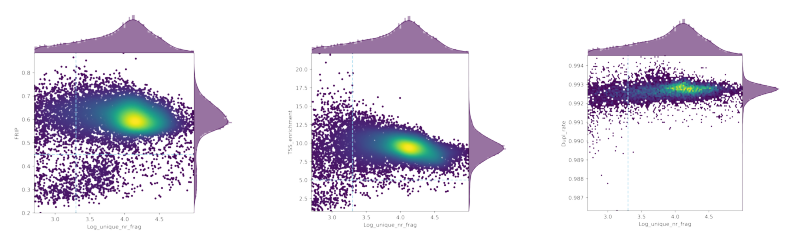

In [37]:
# Filter cell barcodes 

# TIMECOURSE #

                            #[min,  #max]
QC_filters = {
    'Log_unique_nr_frag': [3.3 , None],
    'FRIP':               [0.45, None],
    'TSS_enrichment':     [5   , None],
    'Dupl_rate':          [None, None]

}

# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig_tc, FRIP_NR_FRAG_filter_tc=plot_barcode_metrics(metadata_bc['timecourse'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=QC_filters['Log_unique_nr_frag'][0],
                                       max_x=QC_filters['Log_unique_nr_frag'][1],
                                       min_y=QC_filters['FRIP'][0],
                                       max_y=QC_filters['FRIP'][1],
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False)
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig_tc, TSS_NR_FRAG_filter_tc=plot_barcode_metrics(metadata_bc['timecourse'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['TSS_enrichment'][0],
                                      max_y=QC_filters['TSS_enrichment'][1],
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False)
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig_tc=plot_barcode_metrics(metadata_bc['timecourse'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['Dupl_rate'][0],
                                      max_y=QC_filters['Dupl_rate'][1],
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

# Plot barcode stats in one figure
fig=plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig_tc)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig_tc)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig_tc)
plt.imshow(img)
plt.axis('off')
plt.show()

/g/scb/zaugg/deuner/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1871: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/g/scb/zaugg/deuner/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1886: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/g/scb

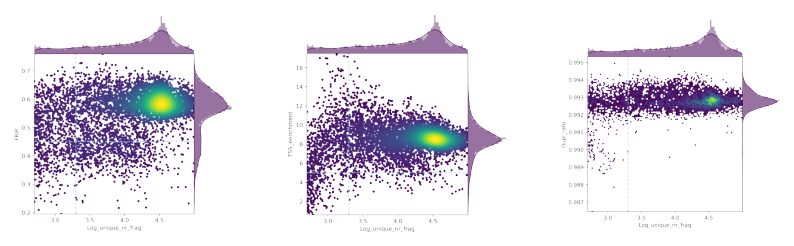

In [38]:
# Filter cell barcodes 

# NEURON #

                            #[min,  #max]
QC_filters = {
    'Log_unique_nr_frag': [3.3 , None],
    'FRIP':               [0.45, None],
    'TSS_enrichment':     [5   , None],
    'Dupl_rate':          [None, None]

}

# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig_neur, FRIP_NR_FRAG_filter_neur=plot_barcode_metrics(metadata_bc['Neuron'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=QC_filters['Log_unique_nr_frag'][0],
                                       max_x=QC_filters['Log_unique_nr_frag'][1],
                                       min_y=QC_filters['FRIP'][0],
                                       max_y=QC_filters['FRIP'][1],
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False)
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig_neur, TSS_NR_FRAG_filter_neur=plot_barcode_metrics(metadata_bc['Neuron'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['TSS_enrichment'][0],
                                      max_y=QC_filters['TSS_enrichment'][1],
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False)
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig_neur=plot_barcode_metrics(metadata_bc['Neuron'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['Dupl_rate'][0],
                                      max_y=QC_filters['Dupl_rate'][1],
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

# Plot barcode stats in one figure
fig=plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig_neur)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig_neur)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig_neur)
plt.imshow(img)
plt.axis('off')
plt.show()

/g/scb/zaugg/deuner/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1871: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/g/scb/zaugg/deuner/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1886: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/g/scb

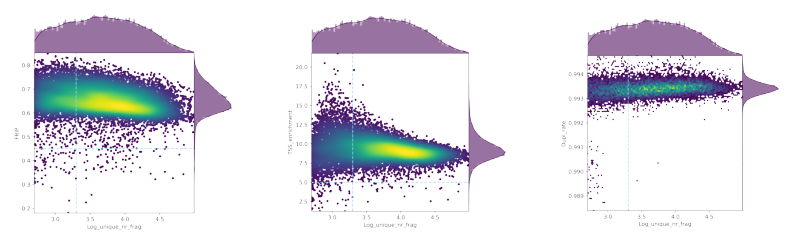

In [39]:
# Filter cell barcodes 

# NPC #

                            #[min,  #max]
QC_filters = {
    'Log_unique_nr_frag': [3.3 , None],
    'FRIP':               [0.45, None],
    'TSS_enrichment':     [5   , None],
    'Dupl_rate':          [None, None]

}

# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig_npc, FRIP_NR_FRAG_filter_npc=plot_barcode_metrics(metadata_bc['NPC'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=QC_filters['Log_unique_nr_frag'][0],
                                       max_x=QC_filters['Log_unique_nr_frag'][1],
                                       min_y=QC_filters['FRIP'][0],
                                       max_y=QC_filters['FRIP'][1],
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False)
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig_npc, TSS_NR_FRAG_filter_npc=plot_barcode_metrics(metadata_bc['NPC'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['TSS_enrichment'][0],
                                      max_y=QC_filters['TSS_enrichment'][1],
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False)
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig_npc=plot_barcode_metrics(metadata_bc['NPC'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['Dupl_rate'][0],
                                      max_y=QC_filters['Dupl_rate'][1],
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

# Plot barcode stats in one figure
fig=plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig_npc)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig_npc)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig_npc)
plt.imshow(img)
plt.axis('off')
plt.show()

/g/scb/zaugg/deuner/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1871: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/g/scb/zaugg/deuner/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1886: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/g/scb

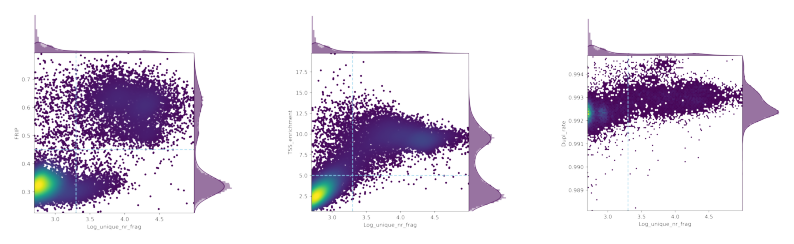

In [40]:
# Filter cell barcodes 

# COCULTURED28 #

                            #[min,  #max]
QC_filters = {
    'Log_unique_nr_frag': [3.3 , None],
    'FRIP':               [0.45, None],
    'TSS_enrichment':     [5   , None],
    'Dupl_rate':          [None, None]

}

# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig_c28, FRIP_NR_FRAG_filter_c28=plot_barcode_metrics(metadata_bc['cocultured28'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=QC_filters['Log_unique_nr_frag'][0],
                                       max_x=QC_filters['Log_unique_nr_frag'][1],
                                       min_y=QC_filters['FRIP'][0],
                                       max_y=QC_filters['FRIP'][1],
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False)
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig_c28, TSS_NR_FRAG_filter_c28=plot_barcode_metrics(metadata_bc['cocultured28'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['TSS_enrichment'][0],
                                      max_y=QC_filters['TSS_enrichment'][1],
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False)
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig_c28=plot_barcode_metrics(metadata_bc['cocultured28'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['Dupl_rate'][0],
                                      max_y=QC_filters['Dupl_rate'][1],
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

# Plot barcode stats in one figure
fig=plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig_c28)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig_c28)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig_c28)
plt.imshow(img)
plt.axis('off')
plt.show()

In [41]:
bc_passing_filters = {'timecourse':[], 'Neuron':[], 'NPC':[], 'cocultured28':[]}
bc_passing_filters['timecourse'] = list((set(FRIP_NR_FRAG_filter_tc) & set(TSS_NR_FRAG_filter_tc)))
bc_passing_filters['Neuron'] = list((set(FRIP_NR_FRAG_filter_neur) & set(TSS_NR_FRAG_filter_neur)))
bc_passing_filters['NPC'] = list((set(FRIP_NR_FRAG_filter_npc) & set(TSS_NR_FRAG_filter_npc)))
bc_passing_filters['cocultured28'] = list((set(FRIP_NR_FRAG_filter_c28) & set(TSS_NR_FRAG_filter_c28)))
pickle.dump(bc_passing_filters,
            open(os.path.join(tmp_dir, 'scATAC/quality_control/bc_passing_filters.pkl'), 'wb'))
print(f"{len(bc_passing_filters['timecourse']) + len(bc_passing_filters['Neuron']) + len(bc_passing_filters['NPC']) + len(bc_passing_filters['cocultured28'])} barcodes passed QC stats")

28406 barcodes passed QC stats
